# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
#pip install tensorflow

In [2]:

# Import libraries
import numpy as np
import pandas as pd 

import os
import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop



#from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Embedding
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split  
 
 
import keras_tuner as kt


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

In [3]:
pd.set_option('display.max_colwidth', None)   # no limit
pd.set_option('display.max_columns', None)   # show all columns
pd.set_option('display.width', 2000)         # increase output width


#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [4]:
# Define a function to load data and aggregate them


def load_and_merge_stock_data(file_list, drop_cols=None):
    """
    Reads multiple stock CSV files, adds stock names, 
    drops unnecessary columns, and returns one combined dataframe.
    
    Parameters:
        file_list (list): list of CSV file paths
        drop_cols (list): columns to drop from each dataframe (optional)

    Returns:
        pd.DataFrame: merged dataframe containing all stock data
    """
    
    df_list = []

    for file in file_list:
        
        # ---- Extract stock name from filename ----
        # Example: "AAPL_stock.csv" → "AAPL"
        stock_name = os.path.basename(file).split('.')[0]
        
        # ---- Read CSV ----
        df = pd.read_csv(file)
        
        # ---- Add stock name column ----
        df['Stock'] = stock_name
        
        # ---- Drop unnecessary columns ----
        if drop_cols:
            df = df.drop(columns=drop_cols, errors='ignore')
        
        # Store processed dataframe
        df_list.append(df)

    # ---- Join all dataframes into one ----
    merged_df = pd.concat(df_list, ignore_index=True)
    
    return merged_df



In [5]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
files = [
   # 'RNN_Stocks_Data/AMZN_stocks_data.csv'
   # 'RNN_Stocks_Data/GOOGL_stocks_data.csv'
    'RNN_Stocks_Data/MSFT_stocks_data.csv'
   # 'RNN_Stocks_Data/IBM_stocks_data.csv'
]

# Columns you want to remove (example)
#columns_to_drop = ["Adj Close", "Unnamed: 0"]
columns_to_drop =[]
final_df = load_and_merge_stock_data(files, drop_cols=columns_to_drop)

print(final_df.head())

final_df.shape


         Date   Open   High    Low  Close     Volume  Name             Stock
0  2006-01-03  26.25  27.00  26.10  26.84   79974418  MSFT  MSFT_stocks_data
1  2006-01-04  26.77  27.08  26.77  26.97   57975661  MSFT  MSFT_stocks_data
2  2006-01-05  26.96  27.13  26.91  26.99   48247610  MSFT  MSFT_stocks_data
3  2006-01-06  26.89  27.00  26.49  26.91  100969092  MSFT  MSFT_stocks_data
4  2006-01-09  26.93  27.07  26.76  26.86   55627836  MSFT  MSFT_stocks_data


(3019, 8)

In [6]:
# View specifics of the data
aa=final_df.groupby('Stock')
for name, group in aa:
    print(f"Stock: {name}, Records: {len(group)}")

final_df.info(), final_df.describe()



Stock: MSFT_stocks_data, Records: 3019
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
 7   Stock   3019 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 188.8+ KB


(None,
               Open         High          Low        Close        Volume
 count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03
 mean     36.496817    36.827903    36.173190    36.513412  5.161762e+07
 std      14.683337    14.742483    14.620057    14.694656  3.114958e+07
 min      15.200000    15.620000    14.870000    15.150000  7.425603e+06
 25%      26.785000    27.045000    26.535000    26.835000  3.136557e+07
 50%      29.990000    30.230000    29.780000    30.000000  4.617529e+07
 75%      44.545000    44.980000    44.090000    44.400000  6.322291e+07
 max      87.120000    87.500000    86.230000    86.850000  5.910786e+08)

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [7]:
# Handle Missing Values

final_df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
Stock     0
dtype: int64

In [8]:
final_df.ffill(inplace=True)

In [9]:
final_df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
Stock     0
dtype: int64

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

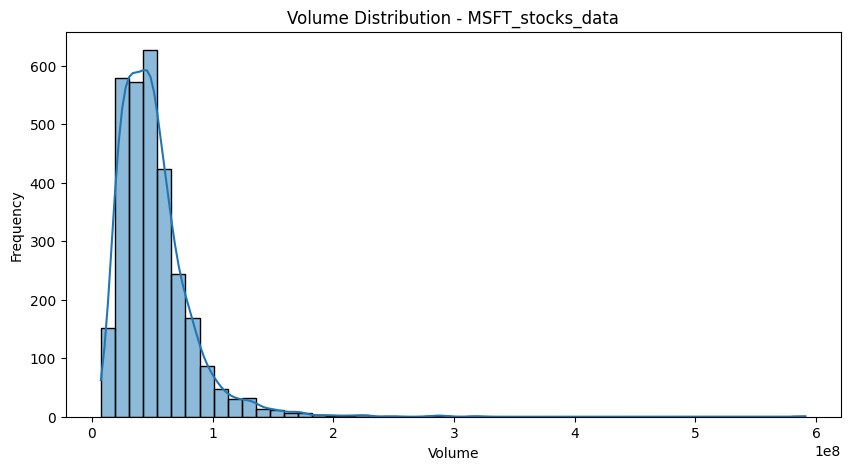

In [10]:
# Frequency distribution of volumes

# If Date is not datetime
final_df['Date'] = pd.to_datetime(final_df['Date'])

companies = final_df['Stock'].unique()

for company in companies:
    plt.figure(figsize=(10, 5))
    
    data = final_df[final_df['Stock'] == company]
    
    sns.histplot(data['Volume'], bins=50, kde=True)
    
    plt.title(f"Volume Distribution - {company}")
    plt.xlabel("Volume")
    plt.ylabel("Frequency")
    
    plt.show()




In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3019 non-null   datetime64[ns]
 1   Open    3019 non-null   float64       
 2   High    3019 non-null   float64       
 3   Low     3019 non-null   float64       
 4   Close   3019 non-null   float64       
 5   Volume  3019 non-null   int64         
 6   Name    3019 non-null   object        
 7   Stock   3019 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 188.8+ KB


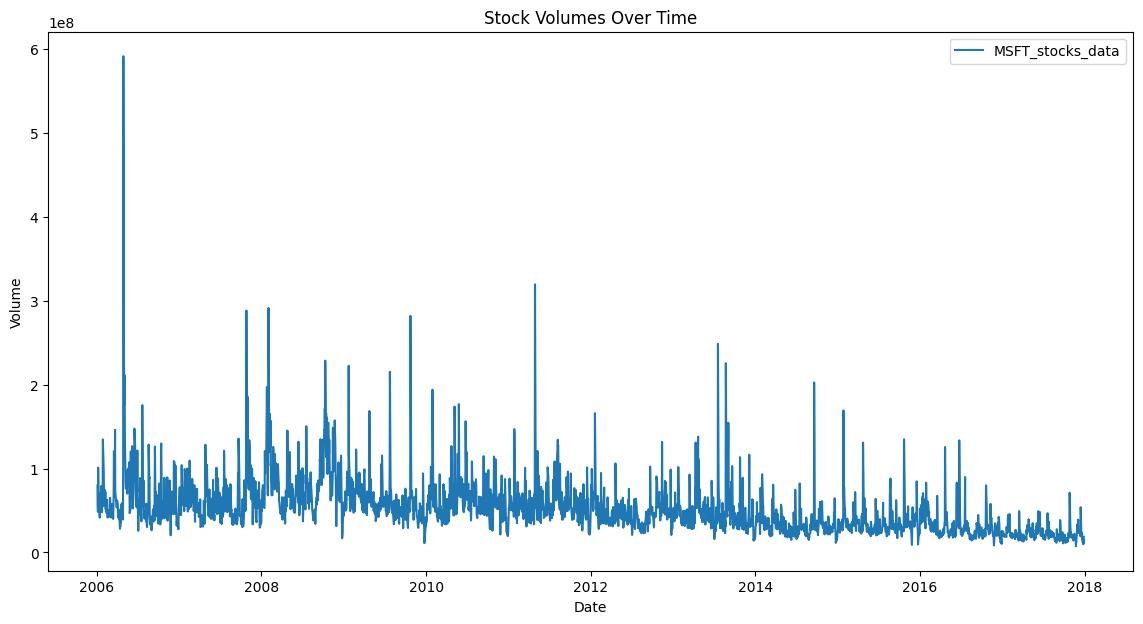

In [12]:
# Stock volume variation over time

plt.figure(figsize=(14,7))
for stock in final_df['Stock'].unique():
    df_stock = final_df[final_df['Stock'] == stock]
    plt.plot(df_stock['Date'], df_stock['Volume'], label=stock)

plt.title("Stock Volumes Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()


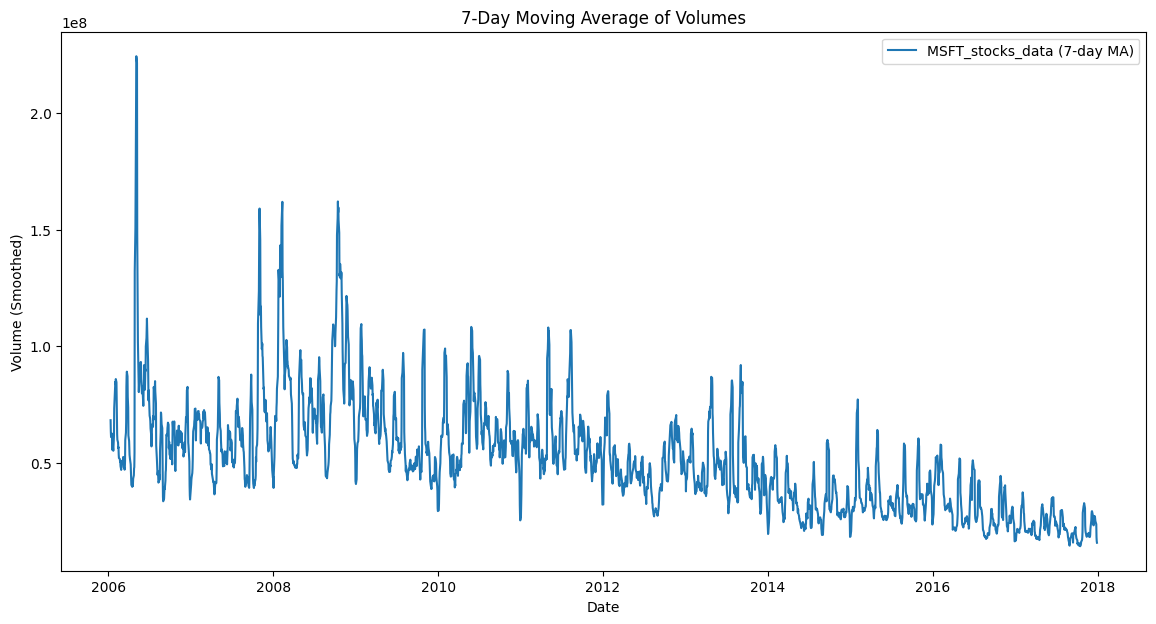

In [13]:
final_df['Volume_Rolling'] = final_df.groupby("Stock")['Volume'].transform(lambda x: x.rolling(7).mean())

plt.figure(figsize=(14,7))
for stock in final_df['Stock'].unique():
    df_stock = final_df[final_df['Stock'] == stock]
    plt.plot(df_stock['Date'], df_stock['Volume_Rolling'], label=f"{stock} (7-day MA)")

plt.title("7-Day Moving Average of Volumes")
plt.xlabel("Date")
plt.ylabel("Volume (Smoothed)")
plt.legend()
plt.show()


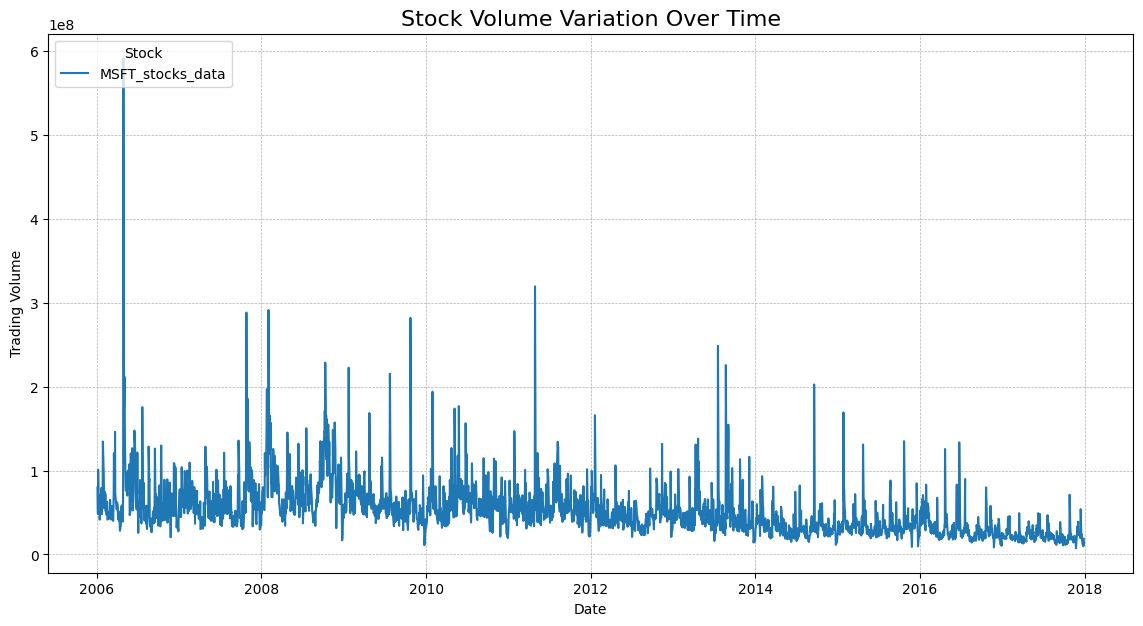

In [14]:


# Ensure Date is a datetime
final_df['Date'] = pd.to_datetime(final_df['Date'])

plt.figure(figsize=(14,7))

# Plot each stock separately
for stock in final_df['Stock'].unique():
    df_stock = final_df[final_df['Stock'] == stock]
    plt.plot(df_stock['Date'], df_stock['Volume'], label=stock, linewidth=1.5)

plt.title("Stock Volume Variation Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.legend(title="Stock", loc="upper left")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

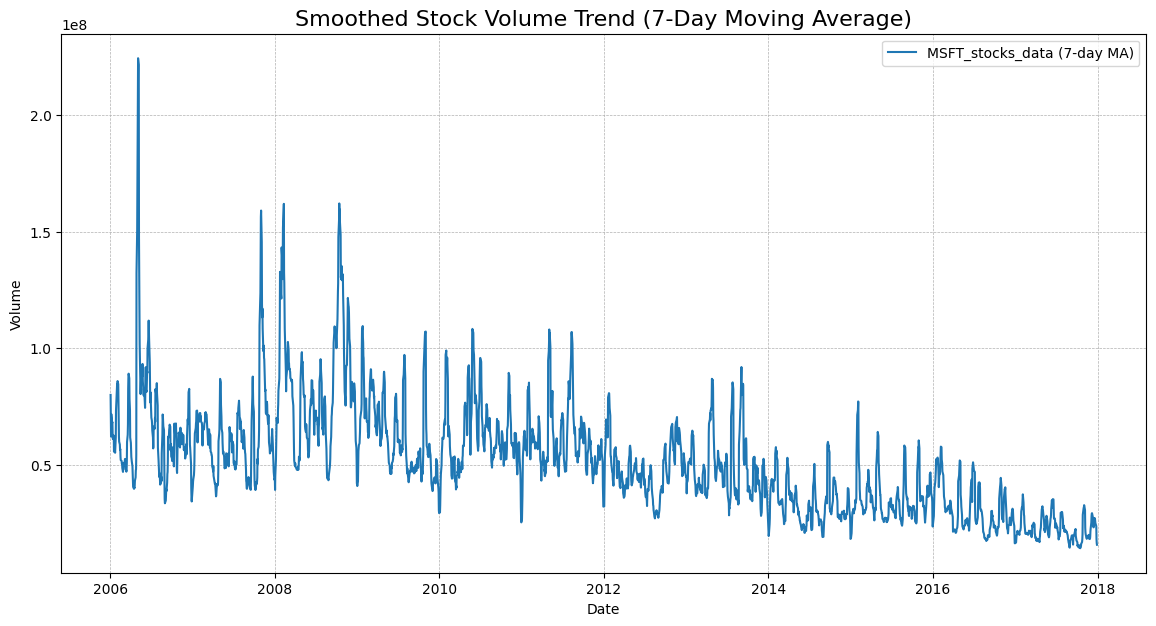

In [15]:
final_df['Volume_Rolling'] = (
    final_df.groupby("Stock")['Volume']
            .transform(lambda x: x.rolling(7, min_periods=1).mean())
)

plt.figure(figsize=(14,7))
for stock in final_df['Stock'].unique():
    df_stock = final_df[final_df['Stock'] == stock]
    plt.plot(df_stock['Date'], df_stock['Volume_Rolling'], label=f"{stock} (7-day MA)")

plt.title("Smoothed Stock Volume Trend (7-Day Moving Average)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

In [16]:
# Analyse correlations

# Select only numeric columns
numeric_df = final_df.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_df.corr()
corr_matrix


,Open,High,Low,Close,Volume,Volume_Rolling
Open,1.000000,0.999792,0.999758,0.999565,-0.483486,-0.632488
High,0.999792,1.000000,0.999703,0.999786,-0.479079,-0.629600
Low,0.999758,0.999703,1.000000,0.999790,-0.489700,-0.636324
Close,0.999565,0.999786,0.999790,1.000000,-0.485328,-0.633892
Volume,-0.483486,-0.479079,-0.489700,-0.485328,1.000000,0.730574
Volume_Rolling,-0.632488,-0.629600,-0.636324,-0.633892,0.730574,1.000000


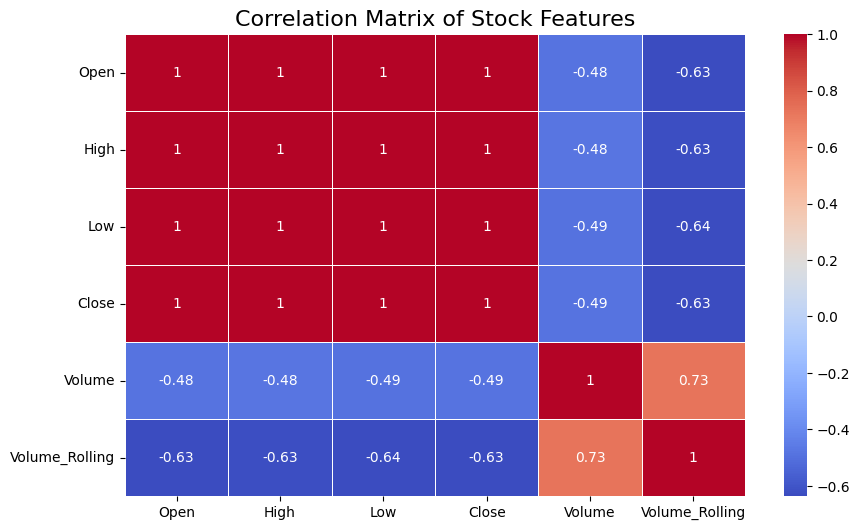

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Stock Features", fontsize=16)
plt.show()


### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [18]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_data(df, window_size=5, step_size=1, target_stocks=["AAPL"]):
 
    df = df.sort_values(["Date", "Name"]).reset_index(drop=True)

    print("df.shape[0]=",df.shape[0]) 

    X_windows = []
    y_targets = []

    # Create wide pivot table: each day's row contains all stocks' features
    pivot_df = df.pivot(index="Date", columns="Name", values="Close")
    #print(df)
    print(pivot_df)
    
    # drop days where any stock has missing values
    pivot_df = pivot_df.dropna()

    # total number of valid rows
    total_rows = pivot_df.shape[0]

    print("total_rows=",total_rows)
    # Iterate through windowed positions
    for start in range(0, total_rows - window_size, step_size):
        end = start + window_size

        # window X → past `window_size` days
        X_window = pivot_df.iloc[start:end]

        # y → next day's close values of target stocks
        y = pivot_df.loc[pivot_df.index[end], target_stocks].values

        X_windows.append(X_window)
        y_targets.append(y)

    return X_windows, y_targets



#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [19]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows



def scale_windowed_data(X_windows, y_targets):
    """
    Scales windowed X data and y targets using MinMaxScaler.
    Returns scaled windows, scaled targets, and scalers.
    """

    # ---------- SCALE X WINDOWS -------------------
    # stack all windows into 2D array
    X_concat = np.vstack([w.reshape(-1, w.shape[-1]) for w in X_windows])

    scaler_X = MinMaxScaler()
    scaler_X.fit(X_concat)

    # scale each window
    X_scaled = np.array([scaler_X.transform(w.reshape(-1, w.shape[-1])).reshape(w.shape) for w in X_windows])

    # ---------- SCALE y TARGETS -------------------
    y_targets = np.array(y_targets).reshape(-1, 1)
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_targets).flatten()

    return X_scaled, y_scaled, scaler_X, scaler_y



Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [20]:
# Define a function to create input and output data points from the master DataFrame

def prepare_stock_data(
    df,
    target_stocks,
    window_size=10,
    step_size=1,
    train_ratio=0.8
):
    # 1. ---- Create windowed X and y ----
    X_windows, y_targets = create_windowed_data(
        df,
        window_size=window_size,
        step_size=step_size,
        target_stocks=target_stocks
    )

    # 2. ---- Train-test split ----
    train_size = int(len(X_windows) * train_ratio)

    X_train = np.array(X_windows[:train_size])     # <-- convert to array
    y_train = np.array(y_targets[:train_size])

    X_test = np.array(X_windows[train_size:])      # <-- convert to array
    y_test = np.array(y_targets[train_size:])

    # 3. ---- Scale training windows ----
    X_train_scaled, y_train_scaled, x_scaler, y_scaler = scale_windowed_data(
        X_train,
        y_train
    )

    print("Scaled X window shape:", X_train_scaled[0].shape)
    print("Scaled First X:", X_train_scaled[0])
    print("Scaled first y:", y_train_scaled[0])

    # 4. ---- Apply SAME scalers to test windows ----
    num_test, w, f = X_test.shape

    # reshape test windows (windows*w, f)
    X_test_2d = X_test.reshape(-1, f)

    # scale using training scaler
    X_test_scaled_2d = x_scaler.transform(X_test_2d)

    # reshape back
    X_test_scaled = X_test_scaled_2d.reshape(num_test, w, f)

    # scale test targets
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

    return (
        X_train_scaled,
        y_train_scaled,
        X_test_scaled,
        y_test_scaled,
        x_scaler,
        y_scaler
    )



We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [21]:
# final_df['Date'] = pd.to_datetime(final_df['Date'], errors='coerce')

# final_df = final_df.sort_values('Date')
# final_df = final_df.set_index('Date')

# print(type(final_df.index))

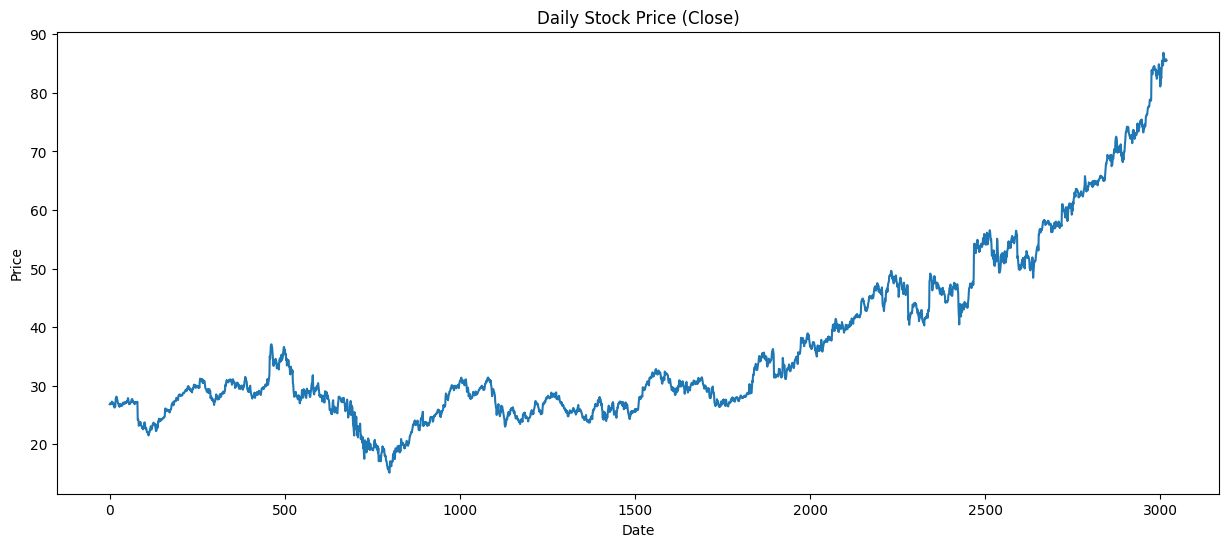

In [59]:
# Checking for patterns in different sequence lengths
plt.figure(figsize=(15,6))
plt.plot(final_df['Close'])
plt.title("Daily Stock Price (Close)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [ ]:
# =========================================
# 1. Load Data
# =========================================

df = final_df.copy()           # your dataframe
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

data = df['Close'].values.reshape(-1, 1)

# Scale data 0–1 for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# =========================================
# 2. Create sliding window dataset
# =========================================

def create_sequences(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i : i + window_size])
        y.append(dataset[i + window_size])
    return np.array(X), np.array(y)

# =========================================
# 3. Train & evaluate model for each window size
# =========================================

WINDOW_SIZES = [15, 30, 45, 60, 90, 120]
#WINDOW_SIZES = [3, 10,180]
results = {}

for w in WINDOW_SIZES:
    print(f"\nTraining model with window size = {w}")

    X, y = create_sequences(scaled_data, w)

    # reshape for LSTM → (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # train-test split (80% train, 20% test)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # --------------------------
    # LSTM MODEL
    # --------------------------
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(w, 1)),
        LSTM(32),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        verbose=0
    )

    # Evaluate model
    loss = model.evaluate(X_test, y_test, verbose=0)
    results[w] = loss

    print(f"Window {w} => Test MSE: {loss:.6f}")

# =========================================
# 4. Choose best window
# =========================================

best_window = min(results, key=results.get)
print("\n==============================")
print("       FINAL RESULTS")
print("==============================")
for w, loss in results.items():
    print(f"Window {w}: Loss = {loss:.6f}")

print("\nBest window size =", best_window)
print("==============================")



Training model with window size = 15
Window 15 => Test MSE: 0.000601

Training model with window size = 30
Window 30 => Test MSE: 0.001271

Training model with window size = 45
Window 45 => Test MSE: 0.000297

Training model with window size = 60
Window 60 => Test MSE: 0.000423

Training model with window size = 90
Window 90 => Test MSE: 0.001175

Training model with window size = 120
Window 120 => Test MSE: 0.000628

       FINAL RESULTS
Window 15: Loss = 0.000601
Window 30: Loss = 0.001271
Window 45: Loss = 0.000297
Window 60: Loss = 0.000423
Window 90: Loss = 0.001175
Window 120: Loss = 0.000628

Best window size = 45


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [ ]:
# Create data instances from the master data frame using decided window size and window stride

X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, x_scaler, y_scaler = prepare_stock_data(
    final_df,
    target_stocks=["MSFT"],
    window_size=best_window,
    step_size=1,
    train_ratio=0.8
)




df.shape[0]= 3019
Name         MSFT
Date             
2006-01-03  26.84
2006-01-04  26.97
2006-01-05  26.99
2006-01-06  26.91
2006-01-09  26.86
...           ...
2017-12-22  85.51
2017-12-26  85.40
2017-12-27  85.71
2017-12-28  85.72
2017-12-29  85.54

[3019 rows x 1 columns]
total_rows= 3019
Scaled X window shape: (45, 1)
Scaled First X: [[0.33923389]
 [0.34300638]
 [0.34358677]
 [0.34126524]
 [0.33981428]
 [0.34387696]
 [0.35229251]
 [0.34793964]
 [0.3493906 ]
 [0.34358677]
 [0.3389437 ]
 [0.34445734]
 [0.32675566]
 [0.32501451]
 [0.32298317]
 [0.32646547]
 [0.32936738]
 [0.36680209]
 [0.37289611]
 [0.37724898]
 [0.37405688]
 [0.36360998]
 [0.3595473 ]
 [0.34881021]
 [0.34213581]
 [0.34126524]
 [0.33401045]
 [0.33488102]
 [0.32617528]
 [0.33372026]
 [0.34039466]
 [0.33836332]
 [0.33517121]
 [0.33052815]
 [0.3357516 ]
 [0.33401045]
 [0.33313987]
 [0.34532792]
 [0.34010447]
 [0.34793964]
 [0.34300638]
 [0.34184562]
 [0.34126524]
 [0.34561811]
 [0.35113175]]
Scaled first y: 0.3438769587

In [63]:
# Check the number of data points generated
X_train_scaled.shape, y_train_scaled.shape, X_test_scaled.shape, y_test_scaled.shape

((2379, 45, 1), (2379,), (595, 45, 1), (595,))

**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [30]:
# Check if the datasets are compatible inputs to neural networks
def check_dataset_compatibility(X, y, window):
    print("=== DATASET COMPATIBILITY CHECK ===")

    # 1. Missing values
    print("\n1. Checking NaNs:")
    if np.isnan(X).any() or np.isnan(y).any():
        print("NaNs found! Fill or remove them.")
    else:
        print("No NaNs found.")

    # 2. Shape correctness
    print("\n2. Checking shapes:")
    print("X shape:", X.shape)
    print("y shape:", y.shape)

    if len(X.shape) != 3:
        print("X must be 3D (samples, window, features)")
    else:
        print("X is 3D")

    if len(y.shape) not in (1, 2):
        print("y must be 1D or 2D")
    else:
        print("y shape OK")

    # 3. Window size
    print("\n3. Window size check:")
    if X.shape[1] != window:
        print(f"Window mismatch! Expected {window}, found {X.shape[1]}")
    else:
        print("Window size matches")

    # 4. Feature count
    print("\n4. Checking feature dimension:")
    if X.shape[2] < 1:
        print("No features found!")
    else:
        print(f"Number of features: {X.shape[2]}")

    # 5. Sample count
    print("\n5. Checking sample count:")
    if X.shape[0] != y.shape[0]:
        print("Mismatch between X and y samples")
    else:
        print("Sample count matches")

    print("\n=== COMPATIBILITY CHECK COMPLETE ===")
check_dataset_compatibility(X_train_scaled, y_train_scaled, window=best_window)


=== DATASET COMPATIBILITY CHECK ===

1. Checking NaNs:
No NaNs found.

2. Checking shapes:
X shape: (2379, 45, 1)
y shape: (2379,)
X is 3D
y shape OK

3. Window size check:
Window size matches

4. Checking feature dimension:
Number of features: 1

5. Checking sample count:
Sample count matches

=== COMPATIBILITY CHECK COMPLETE ===


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [31]:
# # Create a function that creates a simple RNN model according to the model configuration arguments
def build_simple_rnn(input_shape, units=32, num_layers=1, dropout=0.0, lr=0.001):
    model = Sequential()
    
    # First SimpleRNN layer
    model.add(SimpleRNN(units, return_sequences=(num_layers > 1),
                        input_shape=input_shape))
    
    if dropout > 0:
        model.add(Dropout(dropout))
    
    # Additional layers
    for i in range(num_layers - 1):
        model.add(SimpleRNN(units, return_sequences=(i < num_layers - 2)))
        if dropout > 0:
            model.add(Dropout(dropout))
    
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model


19/19 [==============================] - 0s 3ms/step

Test MSE of Base Simple RNN Model: 1105.1405
RMSE: 33.2436529732716


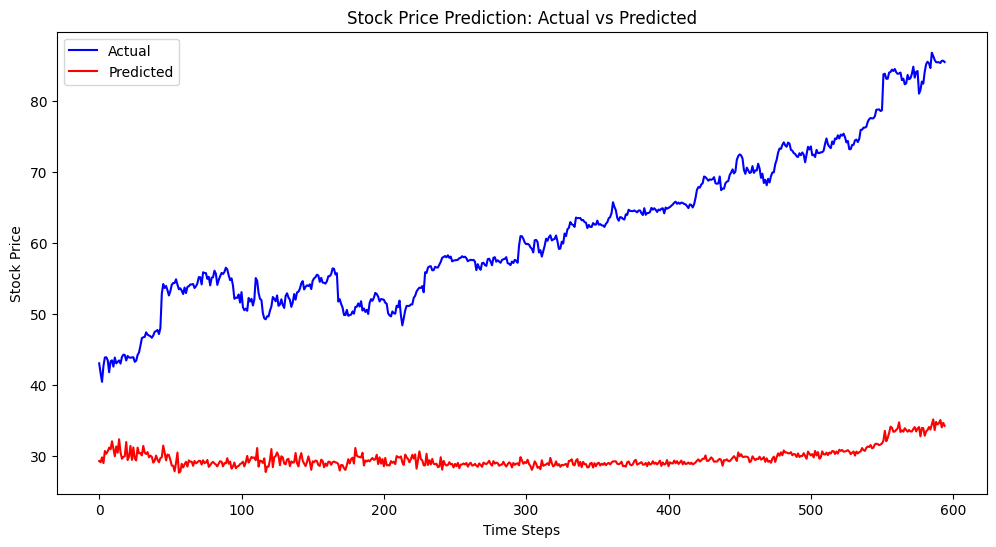

In [32]:
#predict using the base model
model=build_simple_rnn(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    units=32,
    num_layers=2,
    dropout=0.2,
    lr=0.001
)

y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)  

y_test_original = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
# Evaluate predictions
mse = np.mean((y_pred - y_test_original) ** 2)
print(f"\nTest MSE of Base Simple RNN Model: {mse:.4f}")
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# draw predictions vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test_original, label="Actual", color='blue')
plt.plot(y_pred, label="Predicted", color='red')
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()



#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

## Hyperparameter tunning by giving hardcoded list of values for different parameters

In [33]:
# Find an optimal configuration of simple RNN

# -------------------------------------------------------------
# 1️ BUILD MODEL FUNCTION WITH LIST-BASED HYPERPARAMETERS
# -------------------------------------------------------------
def build_model(hp):
    
    model = Sequential()

    # ------------------------
    # RNN TYPE
    # ------------------------
    #rnn_type = hp.Choice("rnn_type", ["SimpleRNN", "LSTM", "GRU"])
    rnn_type = hp.Choice("rnn_type", ["SimpleRNN"])

    # ------------------------
    # NUMBER OF RNN LAYERS
    # ------------------------
    num_layers = hp.Choice("num_layers", [1, 2])

    # ------------------------
    # UNITS PER LAYER
    # ------------------------
    units = hp.Choice("units", [32, 64, 128])

    # ------------------------
    # ACTIVATION FUNCTION
    # ------------------------
    activation = hp.Choice("activation", ["tanh", "relu","linear"])

    # ------------------------
    # DROPOUT
    # ------------------------
    dropout_rate = hp.Choice("dropout", [0.0, 0.2, 0.3, 0.5])

    # ------------------------
    # RECURRENT DROPOUT
    # ------------------------
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.0, 0.2])

    # -----------------------------------------------------------
    # ADD RNN LAYERS
    # -----------------------------------------------------------
    for i in range(num_layers):

        return_sequences = True if i < num_layers - 1 else False

        if rnn_type == "SimpleRNN":
            model.add(SimpleRNN(
                units,
                activation=activation,
                dropout=dropout_rate,
                recurrent_dropout=recurrent_dropout,
                return_sequences=return_sequences
            ))

        elif rnn_type == "LSTM":
            model.add(LSTM(
                units,
                activation=activation,
                dropout=dropout_rate,
                recurrent_dropout=recurrent_dropout,
                return_sequences=return_sequences
            ))

        elif rnn_type == "GRU":
            model.add(GRU(
                units,
                activation=activation,
                dropout=dropout_rate,
                recurrent_dropout=recurrent_dropout,
                return_sequences=return_sequences
            ))

    # -----------------------------------------------------------
    # DENSE LAYER
    # -----------------------------------------------------------
    dense_units = hp.Choice("dense_units", [16, 32, 64])
    model.add(Dense(dense_units, activation="relu"))

    # OUTPUT LAYER
    model.add(Dense(1))

    # -----------------------------------------------------------
    # OPTIMIZER + LEARNING RATE
    # -----------------------------------------------------------
    lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
    opt_name = hp.Choice("optimizer", ["adam", "rmsprop"])

    if opt_name == "adam":
        optimizer = Adam(learning_rate=lr)
    else:
        optimizer = RMSprop(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )

    return model 

# -------------------------------------------------------------
# 2️ SETUP TUNER
# -------------------------------------------------------------
# tuner = kt.GridSearch(
#     hypermodel=build_model,
#     objective="val_loss",
#     directory="gridsearch_results",
#     project_name="stock_lstm",
#     overwrite=True
# )

tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=100,     # increase to explore more combinations
    executions_per_trial=1,
    directory="rnn_tuner",
    project_name="stock_prediction"
)

# -------------------------------------------------------------
# 3️ RUN TUNING
# -------------------------------------------------------------
tuner.search(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=15,          
    batch_size=32       
)





Trial 100 Complete [00h 00m 20s]
val_loss: 0.0022557610645890236

Best val_loss So Far: 0.0003025743062607944
Total elapsed time: 00h 28m 23s


In [34]:
# Find the best configuration based on evaluation metrics

# -------------------------------------------------------------
# 4️ GET BEST HYPERPARAMETERS
# -------------------------------------------------------------
best_hp = tuner.get_best_hyperparameters(1)[0]
for k, v in best_hp.values.items():
    print(f"{k}: {v}")

# -------------------------------------------------------------
# 5️ TRAIN BEST MODEL
# -------------------------------------------------------------
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=50,         # FIXED, not tuned
    batch_size=32
)

# -------------------------------------------------------------
# 6️ PRINT FULL SUMMARY OF ALL TUNED PARAMETERS
# -------------------------------------------------------------
tuner.results_summary(num_trials=50)   # shows best trials + full table 

rnn_type: SimpleRNN
num_layers: 1
units: 64
activation: linear
dropout: 0.0
recurrent_dropout: 0.2
dense_units: 64
learning_rate: 0.001
optimizer: rmsprop
Epoch 1/50
60/60 [==============================] - 2s 16ms/step - loss: 16.4888 - mae: 2.1569 - val_loss: 0.5001 - val_mae: 0.6984
Epoch 2/50
60/60 [==============================] - 1s 12ms/step - loss: 0.2755 - mae: 0.3670 - val_loss: 0.2745 - val_mae: 0.5152
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0257 - mae: 0.1186 - val_loss: 0.1010 - val_mae: 0.3111
Epoch 4/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0053 - mae: 0.0543 - val_loss: 0.0031 - val_mae: 0.0509
Epoch 5/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0015 - mae: 0.0291 - val_loss: 0.0073 - val_mae: 0.0824
Epoch 6/50
60/60 [==============================] - 1s 15ms/step - loss: 7.4619e-04 - mae: 0.0211 - val_loss: 6.8370e-04 - val_mae: 0.0206
Epoch 7/50
60/60 [==============================] 

In [35]:
# print summary of all trials in tabular format
trial_data = []

for trial in tuner.oracle.trials.values():
    row = trial.hyperparameters.values.copy()
    row["score"] = trial.score
    trial_data.append(row)

df = pd.DataFrame(trial_data)
#sore by sorce 
df = df.sort_values(by="score", ascending=True)
print(df)


     rnn_type  num_layers  units activation  dropout  recurrent_dropout  dense_units  learning_rate optimizer      score
35  SimpleRNN           1     64     linear      0.0                0.2           64         0.0010   rmsprop   0.000303
17  SimpleRNN           1     64     linear      0.0                0.0           64         0.0010   rmsprop   0.000334
76  SimpleRNN           1    128       relu      0.0                0.0           16         0.0010      adam   0.000351
68  SimpleRNN           1     32       tanh      0.0                0.2           64         0.0100      adam   0.000362
83  SimpleRNN           1     32       relu      0.0                0.0           64         0.0100   rmsprop   0.000372
..        ...         ...    ...        ...      ...                ...          ...            ...       ...        ...
46  SimpleRNN           1    128     linear      0.2                0.2           64         0.0001      adam   0.293467
24  SimpleRNN           2    128

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [36]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# -------------------------------------------------------------
# 5️ TRAIN BEST MODEL
# -------------------------------------------------------------
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=50,         # FIXED, not tuned
    batch_size=32
)


Epoch 1/50
60/60 [==============================] - 3s 18ms/step - loss: 13.6300 - mae: 1.9002 - val_loss: 0.6188 - val_mae: 0.7789
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.2826 - mae: 0.3631 - val_loss: 0.3687 - val_mae: 0.5987
Epoch 3/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0270 - mae: 0.1236 - val_loss: 0.1466 - val_mae: 0.3745
Epoch 4/50
60/60 [==============================] - 1s 16ms/step - loss: 0.0050 - mae: 0.0535 - val_loss: 0.0314 - val_mae: 0.1720
Epoch 5/50
60/60 [==============================] - 1s 16ms/step - loss: 0.0014 - mae: 0.0279 - val_loss: 0.0092 - val_mae: 0.0914
Epoch 6/50
60/60 [==============================] - 1s 19ms/step - loss: 7.8872e-04 - mae: 0.0216 - val_loss: 0.0036 - val_mae: 0.0547
Epoch 7/50
60/60 [==============================] - 1s 15ms/step - loss: 5.5254e-04 - mae: 0.0181 - val_loss: 0.0065 - val_mae: 0.0769
Epoch 8/50
60/60 [==============================] - 1s 14ms/step - loss: 4

Plotting the actual vs predicted values

In [37]:
# Predict on the test data and plot


y_pred_scaled = best_model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_original = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
# Evaluate predictions
mse = np.mean((y_pred - y_test_original) ** 2)
print(f"\nTest MSE of Best Model: {mse:.4f}")
rmse = np.sqrt(mse)
print("RMSE:", rmse)


19/19 [==============================] - 0s 4ms/step

Test MSE of Best Model: 2.2422
RMSE: 1.4973951833222454


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

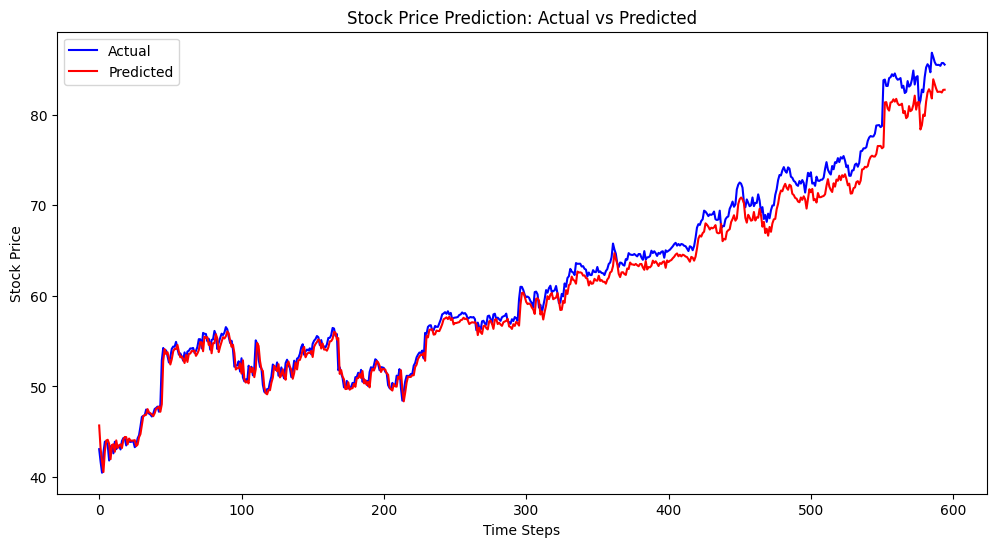

In [38]:
# Compute the performance of the model on the testing data set

# draw predictions vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test_original, label="Actual", color='blue')
plt.plot(y_pred, label="Predicted", color='red')
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [39]:
# # Define a function to create a model and specify default values for hyperparameters

# Find an optimal configuration of simple RNN

# -------------------------------------------------------------
# 1️ BUILD MODEL FUNCTION WITH LIST-BASED HYPERPARAMETERS
# -------------------------------------------------------------
def build_model_adv(hp):
    
    model = Sequential()

    # ------------------------
    # RNN TYPE
    # ------------------------
    rnn_type = hp.Choice("rnn_type", ["LSTM", "GRU"]) 

    # ------------------------
    # NUMBER OF RNN LAYERS
    # ------------------------
    num_layers = hp.Choice("num_layers", [1, 2])

    # ------------------------
    # UNITS PER LAYER
    # ------------------------
    units = hp.Choice("units", [32, 64, 128])

    # ------------------------
    # ACTIVATION FUNCTION
    # ------------------------
    activation = hp.Choice("activation", ["tanh", "relu","linear"])

    # ------------------------
    # DROPOUT
    # ------------------------
    dropout_rate = hp.Choice("dropout", [0.0, 0.2, 0.3, 0.5])

    # ------------------------
    # RECURRENT DROPOUT
    # ------------------------
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.0, 0.2])

    # -----------------------------------------------------------
    # ADD RNN LAYERS
    # -----------------------------------------------------------
    for i in range(num_layers):

        return_sequences = True if i < num_layers - 1 else False

        if rnn_type == "SimpleRNN":
            model.add(SimpleRNN(
                units,
                activation=activation,
                dropout=dropout_rate,
                recurrent_dropout=recurrent_dropout,
                return_sequences=return_sequences
            ))

        elif rnn_type == "LSTM":
            model.add(LSTM(
                units,
                activation=activation,
                dropout=dropout_rate,
                recurrent_dropout=recurrent_dropout,
                return_sequences=return_sequences
            ))

        elif rnn_type == "GRU":
            model.add(GRU(
                units,
                activation=activation,
                dropout=dropout_rate,
                recurrent_dropout=recurrent_dropout,
                return_sequences=return_sequences
            ))

    # -----------------------------------------------------------
    # DENSE LAYER
    # -----------------------------------------------------------
    dense_units = hp.Choice("dense_units", [16, 32, 64])
    model.add(Dense(dense_units, activation="relu"))

    # OUTPUT LAYER
    model.add(Dense(1))

    # -----------------------------------------------------------
    # OPTIMIZER + LEARNING RATE
    # -----------------------------------------------------------
    lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
    opt_name = hp.Choice("optimizer", ["adam", "rmsprop"])

    if opt_name == "adam":
        optimizer = Adam(learning_rate=lr)
    else:
        optimizer = RMSprop(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )

    return model 

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [40]:
# Find an optimal configuration

# -------------------------------------------------------------
# 2️ SETUP TUNER
# -------------------------------------------------------------
tuner_adv = kt.RandomSearch(
    build_model_adv,
    objective="val_loss",
    max_trials=100,     # increase to explore more combinations
    executions_per_trial=1,
    directory="rnn_tuner_advanced",
    project_name="stock_prediction"
)

# tuner_adv = kt.GridSearch(
#     hypermodel=build_model_adv,
#     objective="val_loss",
#     directory="gridsearch_results_adv_model",
#     project_name="stock_lstm",
#     overwrite=True
# )

# -------------------------------------------------------------
# 3️ RUN TUNING
# -------------------------------------------------------------
tuner_adv.search(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=15,          
    batch_size=32       
)

# print summary of all trials in tabular format
trial_data = []

for trial in tuner_adv.oracle.trials.values():
    row = trial.hyperparameters.values.copy()
    row["score"] = trial.score
    trial_data.append(row)

df = pd.DataFrame(trial_data)
#sore by sorce 
df = df.sort_values(by="score", ascending=True)
print(df)


Trial 100 Complete [00h 00m 43s]
val_loss: 0.03926495462656021

Best val_loss So Far: 0.0003093359700869769
Total elapsed time: 01h 03m 40s
   rnn_type  num_layers  units activation  dropout  recurrent_dropout  dense_units  learning_rate optimizer     score
81      GRU           2     64       tanh      0.0                0.0           32         0.0100      adam  0.000309
47      GRU           1    128       tanh      0.0                0.0           64         0.0100      adam  0.000320
0       GRU           2    128     linear      0.0                0.2           64         0.0010      adam  0.000352
36     LSTM           2     32       tanh      0.0                0.0           64         0.0100      adam  0.000357
17      GRU           1     32       tanh      0.0                0.0           64         0.0010      adam  0.000374
..      ...         ...    ...        ...      ...                ...          ...            ...       ...       ...
32     LSTM           2     32    

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [57]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# -------------------------------------------------------------
# 4️ GET BEST HYPERPARAMETERS
# -------------------------------------------------------------
best_hp_adv = tuner_adv.get_best_hyperparameters(1)[0]
for k, v in best_hp_adv.values.items():
    print(f"{k}: {v}")

print("")
# -------------------------------------------------------------
# 5️ TRAIN BEST MODEL
# -------------------------------------------------------------
best_model_adv = tuner_adv.hypermodel.build(best_hp_adv)
history = best_model_adv.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=50,         # FIXED, not tuned
    batch_size=32
)

# -------------------------------------------------------------
# 6️ PRINT FULL SUMMARY OF ALL TUNED PARAMETERS
# -------------------------------------------------------------
tuner_adv.results_summary(num_trials=50)   # shows best trials + full table 


rnn_type: GRU
num_layers: 2
units: 64
activation: tanh
dropout: 0.0
recurrent_dropout: 0.0
dense_units: 32
learning_rate: 0.01
optimizer: adam

Epoch 1/50
60/60 [==============================] - 5s 30ms/step - loss: 0.0132 - mae: 0.0656 - val_loss: 0.0044 - val_mae: 0.0583
Epoch 2/50
60/60 [==============================] - 1s 20ms/step - loss: 2.8552e-04 - mae: 0.0123 - val_loss: 0.0023 - val_mae: 0.0394
Epoch 3/50
60/60 [==============================] - 1s 21ms/step - loss: 2.5020e-04 - mae: 0.0115 - val_loss: 0.0043 - val_mae: 0.0576
Epoch 4/50
60/60 [==============================] - 1s 20ms/step - loss: 2.3734e-04 - mae: 0.0112 - val_loss: 0.0061 - val_mae: 0.0717
Epoch 5/50
60/60 [==============================] - 1s 23ms/step - loss: 2.5521e-04 - mae: 0.0117 - val_loss: 0.0030 - val_mae: 0.0491
Epoch 6/50
60/60 [==============================] - 1s 21ms/step - loss: 2.8769e-04 - mae: 0.0127 - val_loss: 0.0050 - val_mae: 0.0645
Epoch 7/50
60/60 [==============================] 

Plotting the actual vs predicted values

In [42]:
# Predict on the test data
y_pred_scaled=[]
y_pred=[]
y_test_original=[]
y_pred_scaled = best_model_adv.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_original = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
# Evaluate predictions
mse = np.mean((y_pred - y_test_original) ** 2)
print(f"\nTest MSE of Best Model: {mse:.4f}")
rmse = np.sqrt(mse)
print("RMSE:", rmse)

19/19 [==============================] - 1s 8ms/step

Test MSE of Best Model: 4.4553
RMSE: 2.1107560328003694


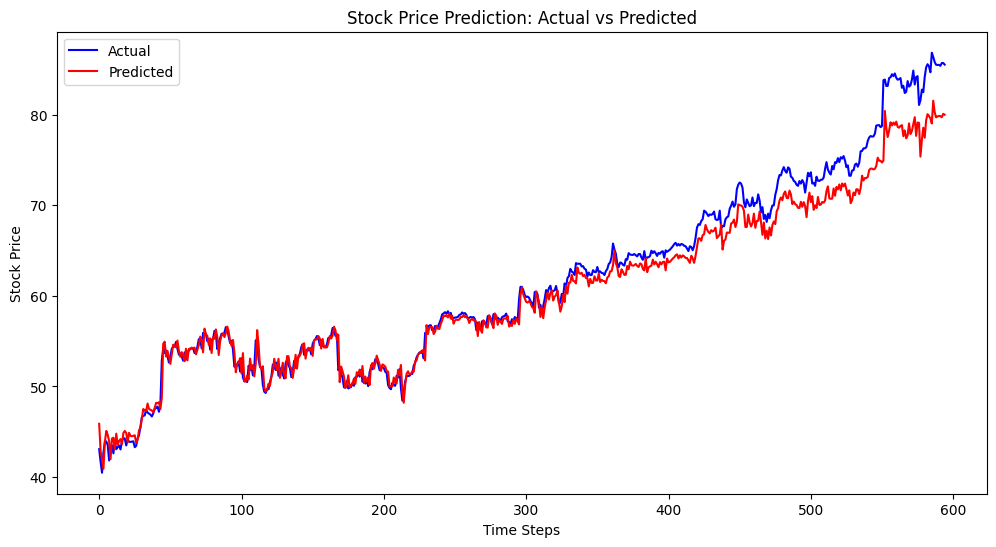

In [58]:
# Compute the performance of the model on the testing data set

# draw predictions vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test_original, label="Actual", color='blue')
plt.plot(y_pred, label="Predicted", color='red')
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [44]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [45]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [46]:
# Find an optimal configuration of simple RNN



In [47]:
# Find the best configuration



In [48]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [49]:
# Compute the performance of the model on the testing data set



In [50]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [51]:
# Find an optimal configuration of advanced RNN



In [52]:
# Find the best configuration



In [53]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [54]:
# Compute the performance of the model on the testing data set



In [55]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

Summary

Built a reproducible RNN pipeline: data aggregation, EDA, windowing, scaling, small LSTM experiments and a window-size sweep, and added code to save/print actual vs predicted values and scalers/models.

Key Findings<br>

Data coverage: Combined stock CSVs into a single final_df; dates converted to datetime and forward-filled missing values.<br>
EDA: Open/High/Low/Close are highly correlated; volumes show different behavior across stocks (some volatile, some stable).<br>
Window-size: We prepared base model to identify loss for different window sizes. window = 45 produced the lowest validation MSE and the largest number of training windows:<br>
Modeling notes: Small LSTM (and SimpleRNN) baseline was used for comparisons. We  added hyperparameter search with KerasTuner.

SimpleRNN model performance after Hyperparameter tunning.<br>
Test MSE of Best Model: 2.2422<br>
RMSE: 1.4973951833222454<br>

Best Model Hyperparameters with SimpleRNN:<br>
rnn_type: SimpleRNN<br>
num_layers: 1<br>
units: 64<br>
activation: linear<br>
dropout: 0.0<br>
recurrent_dropout: 0.2<br>
dense_units: 64<br>
learning_rate: 0.001<br>
optimizer: rmsprop<br>
Score: 0.0003025743062607944<br>

GRE model given best results after Hyperparameter tunning.<br>
Test MSE of Best Model: 4.4553<br>
RMSE: 2.1107560328003694<br>

Best Model Hyperparameters with GRE:<br>
rnn_type: GRU<br>
num_layers: 2<br>
units: 64<br>
activation: tanh<br>
dropout: 0.0<br>
recurrent_dropout: 0.0<br>
dense_units: 32<br>
learning_rate: 0.01<br>
optimizer: adam<br>
Score: 0.0003093359700869769

Volatile stocks - Google  and AMZN<br>
Stable  stocks- MSFT and IBM
 
Open,High,Low, Close are highly correlated with each other <br><br><br>
Volumne is negatively correlated with Stock prices<br><br>
We created windowed datasets for training and testing with a window size of 45 and stride of 1<br>
We used MinMaxScaler to scale the data between 0 and 1 for better model performance<br>
We developed model to identify optimal window size for stock price prediction and found 45 to be the best window size<br>
We built a base Simple RNN model and evaluated its performance<br>
We used Keras Tuner to find the optimal hyperparameters for the Simple RNN model<br>
We retrained the best model and evaluated its performance on the test set<br>
We extended the hyperparameter tuning to include advanced RNN architectures like LSTM and GRU<br>
We retrained the best advanced RNN model and evaluated its performance on the test set model<br>
We used GridSearch Cross Validation scheme for hyperparameter tuning to thoroughly explore combinations of hyperparameters to get the best model performance<br>


 
 
 